<a href="https://colab.research.google.com/github/Amarantine-xiv/Another-FF14-Combat-Sim/blob/main/CoreSimulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2023 A. Falena

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [27]:
VERSION=0.06

In [28]:
#@title Imports

import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import math
from dataclasses import dataclass
import heapq
from enum import Enum
from collections import namedtuple

In [29]:
#@title Game Constants, Util fns
@dataclass(frozen=True)
class GameConsts:
  GCD_RECAST_TIME: float = 2500
  DAMAGE_SNAPSHOT_TIME_BEFORE_CAST_FINISHES = 500
  DH_DAMAGE_MULT_BONUS = 0.25
  # level mods from akhmorning
  LEVEL_DIVS = {90: 1900}
  LEVEL_MAINS= {90: 390}
  LEVEL_SUBS= {90: 400}

def transform_time_to_prio(t):
  return int(1000*t)


In [30]:
#@title StatFns, Stats, ProcessedStats, JobClassFns, DamageClass, ForedCritOrDH
class StatFns:
  @staticmethod
  def get_time_using_speed_stat(t_ms, speed_stat, level=90):
    level_sub = GameConsts.LEVEL_SUBS[level]
    level_div = GameConsts.LEVEL_DIVS[level]

    tmp = np.ceil(130*(level_sub-speed_stat)/level_div)
    tmp2 = t_ms*(1000+tmp)/10000
    tmp3 = np.floor(tmp2)/100
    return int(1000*tmp3)

  @staticmethod
  def get_crit_stats(crit_stat, level=90):
    level_sub = GameConsts.LEVEL_SUBS[level]
    level_div = GameConsts.LEVEL_DIVS[level]

    crit_rate = (np.floor(200*(crit_stat-level_sub)/level_div)+50)/1000
    crit_bonus = (np.floor(200*(crit_stat-level_sub)/level_div)+400)/1000
    return crit_rate, crit_bonus

  @staticmethod
  def get_dh_rate(dh_stat, level=90):
    level_sub = GameConsts.LEVEL_SUBS[level]
    level_div = GameConsts.LEVEL_DIVS[level]
    return np.floor(550*(dh_stat-level_sub)/level_div)/1000

  @staticmethod
  # from Hint's repo, https://github.com/hintxiv/reassemble
  def fWD(wd, job_mod, level=90):
    level_main = GameConsts.LEVEL_MAINS[level]
    return np.floor(level_main*job_mod/1000 + wd)

  @staticmethod
  # from Hint's repo, https://github.com/hintxiv/reassemble
  def fSpd(speed_stat, level=90):
    level_sub = GameConsts.LEVEL_SUBS[level]
    level_div = GameConsts.LEVEL_DIVS[level]
    return np.floor(130 * (speed_stat - level_sub) / level_div + 1000)

  @staticmethod
  def fTnc(tenacity, level=90):
    level_sub = GameConsts.LEVEL_SUBS[level]
    level_div = GameConsts.LEVEL_DIVS[level]
    return (np.floor(100*(tenacity-level_sub)/level_div) + 1000)

  @staticmethod
  # from Hint's repo, https://github.com/hintxiv/reassemble
  def fAP(main_stat, is_tank= False, level=90):
    level_main = GameConsts.LEVEL_MAINS[level]
    if is_tank:
      return np.floor(156*(main_stat-level_main)/level_main) + 100
    return np.floor(195*(main_stat-level_main)/level_main) + 100

  @staticmethod
  # from Hint's repo, https://github.com/hintxiv/reassemble
  def fDet(det_stat, level=90):
    level_main = GameConsts.LEVEL_MAINS[level]
    level_div = GameConsts.LEVEL_DIVS[level]

    return np.floor(140*(det_stat-level_main)/level_div) + 1000

  #Used for auto dh
  @staticmethod
  def fDetDH(det_stat, dh_stat, level= 90):
    level_sub = GameConsts.LEVEL_SUBS[level]
    level_div = GameConsts.LEVEL_DIVS[level]
    return StatFns.fDet(det_stat) + np.floor(140*(dh_stat-level_sub)/level_div)

@dataclass(frozen=True)
class Stats():
  wd: float
  weapon_delay: float
  main_stat: float
  det_stat: float
  dh_stat: float
  crit_stat: float
  speed_stat: float
  job_class: str
  tenacity: float = None
  num_roles_in_party: float = 5
  healer_or_caster_strength: float= None

@dataclass(frozen=True)
class ProcessedStats():
  stats: Stats

  def __init__(self, stats):
    object.__setattr__(self, "stats", stats)
    crit_rate, crit_bonus = StatFns.get_crit_stats(stats.crit_stat)
    object.__setattr__(self, "crit_rate", crit_rate)
    object.__setattr__(self, "crit_bonus", crit_bonus)
    object.__setattr__(self, "det_bonus", StatFns.fDet(stats.det_stat))
    object.__setattr__(self, "dh_rate", StatFns.get_dh_rate(stats.dh_stat))
    object.__setattr__(self, 'job_mod', JobClassFns.JOB_MODS[stats.job_class])
    object.__setattr__(self, 'trait_damage_mult', JobClassFns.compute_trait_damage_mult(stats.job_class))

  def  __str__(self):
    res = 'Crit rate: {}\n'.format(self.crit_rate)
    res += 'Crit bonus: {}\n'.format(self.crit_bonus)
    res += 'Det bonus: {}\n'.format(self.det_bonus)
    res += 'DH Rate: {}\n'.format(self.dh_rate)
    return res

class JobClassFns:

  # See https://www.akhmorning.com/allagan-studies/modifiers/ . Each class' class num is its main attribute #.
  JOB_MODS = {'SCH': 115, 'SGE': 115, 'WHM': 115, 'WAR': 105, 'SAM': 112, 'RPR': 115, 'DRK': 105, 'PLD': 100, 'GNB': 100, 'test_job': 115, 'test_tank_job': 105}

  @staticmethod
  def compute_trait_damage_mult(job_class):
    if job_class == 'SCH':
      return 1.30
    elif job_class == 'SGE':
      return 1.30
    elif job_class == 'WHM':
      return 1.30
    else:
      return 1

  @staticmethod
  def isCaster(job_class):
    return job_class in ['RDM', 'BLM', 'BLU', 'SMN']

  @staticmethod
  def isHealer(job_class):
    return job_class in ['SCH', 'WHM', 'AST', 'SGE']

  @staticmethod
  def isTank(job_class):
    return job_class in ['GNB', 'WAR', 'PLD', 'DRK', 'test_tank_job']

class DamageClass(Enum):
    UNKNOWN = 0
    DIRECT = 1
    DOT = 2
    AUTO = 3
    PET = 4

class ForcedCritOrDH(Enum):
  UNKNOWN = 0
  DEFAULT = 1
  FORCE_NO = 2
  FORCE_YES = 3


In [31]:
#@title DamageSpec, TimingSpec, StatusEffectSpec, FollowUp

@dataclass(frozen=True)
class DamageSpec:
  potency: float = None
  damage_class: DamageClass = DamageClass.DIRECT
  guaranteed_crit: ForcedCritOrDH = ForcedCritOrDH.DEFAULT
  guaranteed_dh: ForcedCritOrDH = ForcedCritOrDH.DEFAULT
  # keep it simple for now- don't include these just yet
  # trait_dmg_mult: float = None
  # pet_job_mod_override: float = None
  # skill_status_effect_denylist: list = None

  def  __str__(self):
    res = '   potency:{}\n'.format(self.potency)
    res += '   damage_class: {}\n'.format(self.damage_class)
    res += '   guaranteed_crit:{}\n'.format(self.guaranteed_crit)
    res += '   guaranteed_dh:{}'.format(self.guaranteed_dh)
    return res

@dataclass(frozen=True)
class TimingSpec:
  base_cast_time: int
  is_GCD: bool
  gcd_base_recast_time: int = None #after you use this skill, how long until you can use a gcd?
  base_recast_time: int = 0 # the base "cooldown" of the skill- when can you use it next?
  animation_lock: int = 65 #does not take into account ping
  application_delay: int = 0 #how long after the cast finishes does the skill get applied

  def __error_check(self):
    #This is such a common error, that we need to defend against it.
    assert isinstance(self.base_cast_time, int), "Base cast time should be an int in ms. Did you put it in seconds?"
    assert isinstance(self.application_delay, int), "Application delay should be an int in ms. Did you put it in seconds?"

  def __post_init__(self):
    if self.gcd_base_recast_time is None:
      if self.is_GCD:
        # assume a default of 2500ms recast time for all gcds, unless otherwise stated
        object.__setattr__(self, 'gcd_base_recast_time', GameConsts.GCD_RECAST_TIME)
      else:
        # By default, non-gcds don't affect gcd_base_recast_time. If this is not
        # true for this skill, then set gcd_base_recast_time explicitly.
        object.__setattr__(self, 'gcd_base_recast_time', 0)
    self.__error_check()

  def __str__(self):
    res = "  Base cast time: {}\n  is_GCD: {}".format(self.base_cast_time, self.is_GCD)
    return res

@dataclass(frozen=True)
class StatusEffectSpec:
  duration: int
  max_duration: int = None
  crit_rate_add: float= 0
  dh_rate_add: float= 0
  damage_mult: float= 1
  main_stat_add: float= 0

  def __post_init__(self):
    if self.max_duration is None:
      object.__setattr__(self, 'max_duration', self.duration)
    assert isinstance(self.duration, int), "Duration should be an int in ms. Did you put it in seconds?"
    assert isinstance(self.max_duration, int), "Max duration should be an int in ms. Did you put it in seconds?"

  def  __str__(self):
    res = '   duration:{}\n'.format(self.duration)
    res += '   max_duration:{}\n'.format(self.max_duration)
    res += '   crit_rate_add:{}\n'.format(self.crit_rate_add)
    res += '   dh_rate_add:{}\n'.format(self.dh_rate_add)
    res += '   damage_mult:{}\n'.format(self.damage_mult)
    res += '   main_stat_add:{}'.format(self.main_stat_add)
    return res

@dataclass(frozen=True)
class FollowUp:
  name: str
  delay_after_parent_application: int
  snapshot_buffs_with_parent: bool = True
  snapshot_debuffs_with_parent: bool = True
  dot_duration: int = None
  dot_tick_interval: int = 3000 #only used if dot_duration is not None

  def __post_init__(self):
    assert self.delay_after_parent_application is None or isinstance(self.delay_after_parent_application, int), "Delay after parent application should an int to represent ms. Did you put it in seconds?"
    assert self.dot_duration is None or isinstance(self.dot_duration, int), "Dot duration should either be none, or an int to represent ms. Did you put it in seconds?"
    assert self.dot_tick_interval is None or isinstance(self.dot_tick_interval, int), "Dot tick interval should either be none, or an int to represent ms. Did you put it in seconds?"

  def __hash__(self):
    return hash(self.name)

In [32]:
#@title Skill, SkillLibrary

@dataclass(frozen=True, order=True)
class Skill:
  # Note: All fields must be either 1) a primitive, 2) a class with the dataclass
  # decorator, or 3) defined with an appropriate __eq__ function.
  name: str
  damage_spec: DamageSpec = None
  timing_spec: TimingSpec = None
  buff_spec: StatusEffectSpec = None
  debuff_spec: StatusEffectSpec = None
  # Follow up skills will be executed in the order given. Use this fact
  # to control whether a buff applies before or after damage has gone out from
  # the skill.
  follow_up_skills: tuple[FollowUp] = None

  def __post_init__(self):
    assert self.follow_up_skills is None or isinstance(self.follow_up_skills, tuple), "Follow up skills must be encoded as a tuple for immutability."

  def __str__(self):
    res = "---Skill name: {}---\n".format(self.name)
    res += "TimingSpec:\n{}\n".format(str(self.timing_spec))
    res += "DamageSpec:\n{}\n".format(self.damage_spec)
    res += "Buffs:\n{}\n".format(self.buff_spec)
    res += "Follow up skills:\n{}\n".format(str(self.follow_up_skills))
    return res

  def __hash__(self):
    return hash(self.name)

class SkillLibrary:
  def __init__(self):
    self._skills = {}

  def get_skill(self, skill_name, job_class):
    return self._skills[job_class][skill_name]

  def add_job_class(self, job_name):
    self._skills[job_name] = {}

  def add_skill(self, skill, job_class):
    skill_name = skill.name
    if skill_name in self._skills[job_class]:
      raise RuntimeError('Duplicate skill being added to the skill library (this is probably a naming error). Job: {}, Skill name: {}'.format(job_class, skill_name))
    self._skills[job_class][skill.name] = skill

  def print_skills(self):
    for job_name in self._skills:
      for skill_name in self._skills[job_name]:
        print("Job name: {}, Skill name: {}".format(job_name, skill_name))

In [33]:
#@title StatusEffects, StatusEffectTracker
@dataclass(frozen=True)
class StatusEffects():
  crit_rate_add: float= 0
  dh_rate_add: float= 0
  damage_mult: float= 1
  main_stat_add: float= 0

class StatusEffectTracker():
  def __init__(self):
    self.buffs = {}
    self.debuffs = {}

  @staticmethod
  def __expire_status_effects(t, status_effects):
    se_skills = list(status_effects.keys())
    for se_skill in se_skills:
      (end_time, _) = status_effects[se_skill]
      if t > end_time:
        del status_effects[se_skill]

  def expire_status_effects(self, t):
    self.__expire_status_effects(t, self.buffs)
    self.__expire_status_effects(t, self.debuffs)

  @staticmethod
  def __add_to_status_effects(status_effects, start_time, skill, is_buff):
    status_effect_spec = skill.buff_spec if is_buff else skill.debuff_spec
    if not skill in status_effects:
      end_time = start_time + status_effect_spec.duration
      status_effects[skill] = (end_time, status_effect_spec)
    else:
      current_end_time, _ = status_effects[skill]
      time_left = current_end_time - start_time
      new_duration = min(status_effect_spec.max_duration, time_left + status_effect_spec.duration)
      status_effects[skill] = (start_time + new_duration, status_effect_spec)

  def add_to_status_effects(self, t, skill):
    if skill.buff_spec is not None:
      self.__add_to_status_effects(self.buffs, t, skill, is_buff=True)
    if skill.debuff_spec is not None:
      self.__add_to_status_effects(self.debuffs, t, skill, is_buff=False)

  @staticmethod
  def __compile_status_effects(status_effects):
    crit_rate_add = 0.0
    dh_rate_add = 0.0
    damage_mult = 1.0
    main_stat_add = 0.0
    for se in status_effects:
      (_, spec) = status_effects[se]
      crit_rate_add += spec.crit_rate_add
      dh_rate_add += spec.dh_rate_add
      damage_mult *= spec.damage_mult
      main_stat_add += spec.main_stat_add
    return StatusEffects(crit_rate_add=crit_rate_add, dh_rate_add=dh_rate_add, damage_mult=damage_mult, main_stat_add=main_stat_add)

  # TODO: to take into account certain buffs/debuffs not applying to certain skills, we can pass in the skill to be used here and do the check.
  def compile_status_effects(self):
    return (self.__compile_status_effects(self.buffs), self.__compile_status_effects(self.debuffs))

In [34]:
#@title SnapshotAndApplicationEvents, RotationBuilder
class SnapshotAndApplicationEvents:
  EventTimes = namedtuple('EventTimes', ['primary', 'secondary'])
  # Encapsulates a heap with data values in the format
  #(priority, EventTimes, skill, (snapshots_buffs, snapshots_debuffs)),
  # indicating whether buffs and debuffs snapshot at the given given time for
  # that skill snapshot_time.
  Event = namedtuple('Event', ['priority', 'event_times', 'skill', 'snapshot_status'])
  def __init__(self):
    self.__q = []

  @staticmethod
  def _create_event(priority, primary_time, secondary_time, skill, snapshot_status):
    event_times = SnapshotAndApplicationEvents.EventTimes(primary=primary_time, secondary=secondary_time)
    return SnapshotAndApplicationEvents.Event(priority=priority,
                                              event_times=event_times,
                                              skill=skill,
                                              snapshot_status=snapshot_status)

  def add(self, priority, primary_time, secondary_time, skill, snapshot_status):
    # If the application and snapshot times are the same, then we can collapse them into 1 timing.
    if primary_time == secondary_time:
      secondary_time = None
      snapshot_status = [True, True]
    heapq.heappush(self.__q, self._create_event(priority, primary_time, secondary_time, skill, snapshot_status))

  def clear(self):
    self.__q.clear()

  def is_empty(self):
    return len(self.__q) == 0

  def get_next(self):
    return heapq.heappop(self.__q)

  def get_q(self):
    return copy.deepcopy(self.__q)

  def __str__(self):
    q = copy.deepcopy(self.__q)
    res = ""
    while len(q) > 0:
      res += str(heapq.heappop(q)) + '\n'
    return res

class RotationBuilder:
  """ A utility class used to turn 1) a series of button (skills) pressed and optionally the specific time they were pressed, and 2) proc application times into a series of damage instances and applicable buffs/debuffs."""
  def __init__(self, stats, skill_library):
    self._stats = stats
    self._skill_library = skill_library
    self._q_timed = [] #(priority, time-pressed, skill)
    self._q_dot_skills = {} #this is a map
    # self._q_snapshot_and_applications = []
    self._q_snapshot_and_applications = SnapshotAndApplicationEvents()

  @staticmethod
  def _print_q(q):
    q.sort(key=lambda x: x[0])
    for (time, skill) in q:
      print('{}: {}'.format(time, skill.name))

  def add_to_rotation(self, skill_name, t):
    """Adds a skill to be used. All skills are considered to be used sequential at the first available opportunity, unless a time t is specified."""
    """ Time is assumed to be in seconds"""
    skill = self._skill_library.get_skill(skill_name, self._stats.job_class)
    heapq.heappush(self._q_timed, (transform_time_to_prio(t), skill))

  @staticmethod
  def __follow_up_is_dot(follow_up_skill):
    return follow_up_skill.dot_duration is not None

  @staticmethod
  def __get_application_time(t, skill):
    return t + skill.timing_spec.cast_time + skill.timing_spec.application_delay

  def __process_dot_follow_up_skill(self, follow_up_dot_skill, priority_modifier, parent_snapshot_time, parent_application_time):
    if follow_up_dot_skill not in self._q_dot_skills:
      self._q_dot_skills[follow_up_dot_skill] = []
    self._q_dot_skills[follow_up_dot_skill].append((parent_snapshot_time, parent_application_time, priority_modifier))

  def __process_non_dot_follow_up_skill(self, follow_up_skill, priority_modifier, parent_snapshot_time, parent_application_time):
      skill = self._skill_library.get_skill(follow_up_skill.name, self._stats.job_class)
      cast_time = StatFns.get_time_using_speed_stat(skill.timing_spec.base_cast_time, self._stats.speed_stat)
      application_time = parent_application_time + follow_up_skill.delay_after_parent_application + cast_time + skill.timing_spec.application_delay

      if follow_up_skill.snapshot_buffs_with_parent or follow_up_skill.snapshot_debuffs_with_parent:
        snapshot_time = parent_snapshot_time
        snapshot_status = [follow_up_skill.snapshot_buffs_with_parent, follow_up_skill.snapshot_debuffs_with_parent]
      else:
        snapshot_time = application_time
        snapshot_status = [True, True]
      priority = transform_time_to_prio(snapshot_time)
      self._q_snapshot_and_applications.add(priority+priority_modifier, snapshot_time, application_time, skill, snapshot_status)

  def _process_follow_up_skills(self, follow_up_skills, parent_snapshot_time, parent_application_time):
    for i in range(0, len(follow_up_skills)):
      # priority modifier is used to ensure follow up skills is such that it happens after its parent, and in order of follow up skills specified
      priority_modifier = i+1
      follow_up_skill = follow_up_skills[i]
      if RotationBuilder.__follow_up_is_dot(follow_up_skill):
        self.__process_dot_follow_up_skill(follow_up_skill, priority_modifier, parent_snapshot_time, parent_application_time)
      else:
        self.__process_non_dot_follow_up_skill(follow_up_skill, priority_modifier, parent_snapshot_time, parent_application_time)

  def __get_base_dot_timings(self, follow_up_dot_skill):
    app_times = []
    dot_times = self._q_dot_skills[follow_up_dot_skill]
    for (parent_snapshot_time, parent_application_time, priority_modifier) in dot_times:
      dot_max_end_time = parent_application_time + follow_up_dot_skill.dot_duration
      # dots may start ticking once the parent skill has been applied
      app_times.append((parent_application_time, dot_max_end_time, parent_snapshot_time, priority_modifier))
    return sorted(app_times, key= lambda x: x[0])

  def __get_consolidated_dot_timing(self, dot_name, base_dot_times):
    consolidated_dots = []
    for i in range(0, len(base_dot_times)):
      curr_start_time, curr_end_time, parent_snapshot_time, priority_modifier = base_dot_times[i]
      if i == len(base_dot_times) - 1:
        possible_end_time = math.inf
      else:
        # We make the current dot end here and don't merge in, because the new
        # dot may snapshot a different set of buffs/debuffs.
        possible_end_time = base_dot_times[i+1][0]
      end_time = min(curr_end_time, possible_end_time)
      consolidated_dots.append((curr_start_time, end_time, parent_snapshot_time, priority_modifier))
    return consolidated_dots

  def _process_all_dots(self):
    for follow_up_dot_skill in self._q_dot_skills:
      base_dot_times = self.__get_base_dot_timings(follow_up_dot_skill)
      consolidated_dot_times = self.__get_consolidated_dot_timing(follow_up_dot_skill, base_dot_times)
      dot_skill = self._skill_library.get_skill(follow_up_dot_skill.name, self._stats.job_class)

      # We use the priority modifier to ensure dot skills 1) are processed after their parent, and
      # 2) a dot tick will be processed after the early dot ticks, even if they snapshot at different times.
      dot_num = 0
      for dot_start_time, dot_end_time, parent_snapshot_time, priority_modifier in consolidated_dot_times:
        for application_time in range(dot_start_time, dot_end_time, follow_up_dot_skill.dot_tick_interval):
          priority = transform_time_to_prio(parent_snapshot_time) + (priority_modifier + dot_num)
          snapshot_status = [follow_up_dot_skill.snapshot_buffs_with_parent, follow_up_dot_skill.snapshot_debuffs_with_parent]
          self._q_snapshot_and_applications.add(priority, parent_snapshot_time, application_time, dot_skill, snapshot_status)
          dot_num += 1

  # Result: a heap encapsualted by SnapshotAndApplicationEvents. See
  # SnapshotAndApplicationEvents's documentation for what the data format is.
  def get_skill_timing(self):
    self._q_snapshot_and_applications.clear()
    q = copy.deepcopy(self._q_timed)
    while len(q) > 0:
      (t, skill) = heapq.heappop(q)
      cast_time = StatFns.get_time_using_speed_stat(skill.timing_spec.base_cast_time, self._stats.speed_stat)
      snapshot_time = t + max(0, cast_time - 500)
      application_time = t + cast_time + skill.timing_spec.application_delay
      priority = transform_time_to_prio(snapshot_time)
      self._q_snapshot_and_applications.add(priority, snapshot_time, application_time, skill, [True, True])

      if skill.follow_up_skills:
        self._process_follow_up_skills(skill.follow_up_skills, snapshot_time, application_time)

    self._process_all_dots()
    return copy.deepcopy(self._q_snapshot_and_applications)

  def print_sequential_rotation(self):
    q = copy.deepcopy(self._q_timed)
    RotationBuilder._print_q(q)

In [35]:
#@title create_test_skill_library

def create_test_skill_library():
  skill_library = SkillLibrary()
  skill_library.add_job_class('test_job')
  skill_library.add_job_class('test_tank_job')

  # TimingSpecs
  gcd_2500 = TimingSpec(base_cast_time=2500, is_GCD=True)
  gcd_instant = TimingSpec(base_cast_time=0, is_GCD=True)
  gcd_2500_app_delay = TimingSpec(base_cast_time=2500, application_delay=100, is_GCD=True)
  ogcd_instant = TimingSpec(base_cast_time=0, is_GCD=False)
  dot_timing = TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=0, application_delay= 0)
  follow_up_timing = TimingSpec(base_cast_time=0, is_GCD=False, animation_lock=0, application_delay= 0)

  # DamageSpecs
  simple_damage = DamageSpec(potency=295)
  simple_tank_damage = DamageSpec(potency=200)
  simple_dot_damage = DamageSpec(potency=70, damage_class=DamageClass.DOT)
  simple_tank_dot_damage = DamageSpec(potency=50, damage_class=DamageClass.DOT)
  guaranteed_dh_damage = DamageSpec(potency=660, guaranteed_dh=ForcedCritOrDH.FORCE_YES)
  guaranteed_crit_damage = DamageSpec(potency=660, guaranteed_crit=ForcedCritOrDH.FORCE_YES)
  guaranteed_crit_dh_damage = DamageSpec(potency=660, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES)

  guaranteed_dh_dot_damage = DamageSpec(potency=50, guaranteed_dh=ForcedCritOrDH.FORCE_YES, damage_class=DamageClass.DOT)
  guaranteed_crit_dot_damage = DamageSpec(potency=50, guaranteed_crit=ForcedCritOrDH.FORCE_YES, damage_class=DamageClass.DOT)
  guaranteed_crit_dh_dot_damage = DamageSpec(potency=50, guaranteed_crit=ForcedCritOrDH.FORCE_YES, guaranteed_dh=ForcedCritOrDH.FORCE_YES, damage_class=DamageClass.DOT)

  # StatusEffectSpecs (buff/debuff)
  simple_buff = StatusEffectSpec(duration=30000, max_duration=60000, crit_rate_add=0.05)
  simple_buff_2 = StatusEffectSpec(duration=10000, crit_rate_add=0.06, dh_rate_add=0.2)
  simple_debuff = StatusEffectSpec(duration=30000, max_duration=60000, damage_mult=1.2)
  simple_debuff_2 = StatusEffectSpec(duration=10000, damage_mult=1.3)

  # Skill creation
  test_gcd = Skill(name='test_gcd', timing_spec = gcd_2500, damage_spec=simple_damage)
  test_tank_gcd = Skill(name='test_tank_gcd', timing_spec = gcd_2500, damage_spec=simple_tank_damage)
  test_gcd_with_app_delay = Skill(name='test_gcd_with_app_delay', timing_spec = gcd_2500_app_delay)
  test_ogcd = Skill(name='test_ogcd', timing_spec = ogcd_instant)
  test_non_dot_follow_up = Skill(name='test_non_dot_follow_up', timing_spec=follow_up_timing)
  test_follow_up = Skill(name='test_follow_up', timing_spec=gcd_2500, follow_up_skills = (FollowUp(name='test_non_dot_follow_up', delay_after_parent_application=0, snapshot_buffs_with_parent=True, snapshot_debuffs_with_parent=True),
                                                                                          FollowUp(name='test_non_dot_follow_up', delay_after_parent_application=3000, snapshot_buffs_with_parent=False, snapshot_debuffs_with_parent=True),
                                                                                          FollowUp(name='test_non_dot_follow_up', delay_after_parent_application=7000, snapshot_buffs_with_parent=False, snapshot_debuffs_with_parent=False)))
  test_dot_tick = Skill(name='test_dot_tick', timing_spec=dot_timing, damage_spec=simple_dot_damage)
  test_tank_dot_tick = Skill(name='test_tank_dot_tick', timing_spec=dot_timing, damage_spec=simple_tank_dot_damage)
  test_dot_gcd = Skill(name='test_dot_gcd', timing_spec=gcd_2500, follow_up_skills = (FollowUp(name='test_dot_tick', delay_after_parent_application=0, dot_duration=15*1000, snapshot_buffs_with_parent= True, snapshot_debuffs_with_parent=True),))
  test_dot_biolysis = Skill(name='test_dot_biolysis', timing_spec=gcd_2500, follow_up_skills = (FollowUp(name='test_dot_tick', delay_after_parent_application=0, dot_duration=30*1000, snapshot_buffs_with_parent= True, snapshot_debuffs_with_parent=True),))
  test_dot_instant_gcd = Skill(name='test_dot_instant_gcd', timing_spec=gcd_instant, follow_up_skills = (FollowUp(name='test_dot_tick', delay_after_parent_application=0, dot_duration=15*1000, snapshot_buffs_with_parent= True, snapshot_debuffs_with_parent=True),))
  test_dot_gcd_with_other_follow_up = Skill(name='test_dot_gcd_with_other_follow_up', timing_spec=gcd_2500, follow_up_skills = (FollowUp(name='test_non_dot_follow_up', delay_after_parent_application=0, snapshot_buffs_with_parent=True, snapshot_debuffs_with_parent=True),
                                                                                                                                FollowUp(name='test_dot_tick', delay_after_parent_application=0, dot_duration=15*1000, snapshot_buffs_with_parent= True, snapshot_debuffs_with_parent=True)))
  test_ground_dot_gcd = Skill(name='test_ground_dot_gcd', timing_spec=gcd_2500, follow_up_skills = (FollowUp(name='test_dot_tick', delay_after_parent_application=0, dot_duration=15*1000, snapshot_buffs_with_parent= True, snapshot_debuffs_with_parent=False),))
  test_simple_damage_gcd = Skill('test_simple_damage_gcd', timing_spec = gcd_2500, damage_spec = simple_damage)
  test_simple_buff_gcd = Skill('test_simple_buff_gcd', timing_spec=gcd_instant, buff_spec=simple_buff)
  test_simple_buff_gcd_2 = Skill('test_simple_buff_gcd_2', timing_spec=gcd_instant, buff_spec=simple_buff_2)
  test_simple_buff_gcd_3 = Skill('test_simple_buff_gcd_3', timing_spec=gcd_2500, buff_spec=simple_buff) #NOT instant cast
  test_simple_debuff_gcd = Skill('test_simple_debuff_gcd', timing_spec=gcd_instant, debuff_spec=simple_debuff)
  test_simple_debuff_gcd_2 = Skill('test_simple_debuff_gcd_2', timing_spec=gcd_instant, debuff_spec=simple_debuff_2)
  test_guaranteed_dh = Skill('test_guaranteed_dh', timing_spec=gcd_instant, damage_spec=guaranteed_dh_damage)
  test_guaranteed_crit = Skill('test_guaranteed_crit', timing_spec=gcd_instant, damage_spec=guaranteed_crit_damage)
  test_guaranteed_crit_dh = Skill('test_guaranteed_crit_dh', timing_spec=gcd_instant, damage_spec=guaranteed_crit_dh_damage)
  test_guaranteed_dh_dot = Skill('test_guaranteed_dh_dot', timing_spec=gcd_instant, damage_spec=guaranteed_dh_dot_damage)
  test_guaranteed_crit_dot = Skill('test_guaranteed_crit_dot', timing_spec=gcd_instant, damage_spec=guaranteed_crit_dot_damage)
  test_guaranteed_crit_dh_dot = Skill('test_guaranteed_crit_dh_dot', timing_spec=gcd_instant, damage_spec=guaranteed_crit_dh_dot_damage)

  skill_library.add_skill(test_gcd, 'test_job')
  skill_library.add_skill(test_ogcd, 'test_job')
  skill_library.add_skill(test_gcd_with_app_delay, 'test_job')
  skill_library.add_skill(test_non_dot_follow_up, 'test_job')
  skill_library.add_skill(test_follow_up, 'test_job')
  skill_library.add_skill(test_dot_gcd, 'test_job')
  skill_library.add_skill(test_ground_dot_gcd, 'test_job')
  skill_library.add_skill(test_dot_tick, 'test_job')
  skill_library.add_skill(test_dot_gcd_with_other_follow_up, 'test_job')
  skill_library.add_skill(test_dot_instant_gcd, 'test_job')
  skill_library.add_skill(test_simple_damage_gcd, 'test_job')
  skill_library.add_skill(test_simple_buff_gcd, 'test_job')
  skill_library.add_skill(test_simple_buff_gcd_2, 'test_job')
  skill_library.add_skill(test_simple_buff_gcd_3, 'test_job')
  skill_library.add_skill(test_simple_debuff_gcd, 'test_job')
  skill_library.add_skill(test_simple_debuff_gcd_2, 'test_job')
  skill_library.add_skill(test_dot_biolysis, 'test_job')
  skill_library.add_skill(test_tank_gcd, 'test_tank_job')
  skill_library.add_skill(test_tank_dot_tick, 'test_tank_job')
  skill_library.add_skill(test_guaranteed_dh, 'test_job')
  skill_library.add_skill(test_guaranteed_crit, 'test_job')
  skill_library.add_skill(test_guaranteed_crit_dh, 'test_job')
  skill_library.add_skill(test_guaranteed_dh_dot, 'test_job')
  skill_library.add_skill(test_guaranteed_crit_dot, 'test_job')
  skill_library.add_skill(test_guaranteed_crit_dh_dot, 'test_job')


  return skill_library


In [36]:
#@title DamageBuilder

class DamageBuilder():
  def __init__(self, skill_library):
    self.__skill_library = skill_library
    self.se = StatusEffectTracker()

  @staticmethod
  def __is_application_time(event_times):
    return event_times.secondary is None

  # output is a list, sorted by timestamp of damage instance (not necessarily in stable-sort order, according to the rotation).
  # Format of the elements of the output: (time, skill, (buffs, debuffs))
  def get_damage_instances(self, q_snapshot_and_applications: SnapshotAndApplicationEvents):
    q = [] # (current_time, skill, (buffs, debuffs))
    q_snapshot_and_applications = copy.deepcopy(q_snapshot_and_applications)
    while not q_snapshot_and_applications.is_empty():
      [priority, event_times, skill, snapshot_status] = q_snapshot_and_applications.get_next()
      current_time = event_times.primary
      is_application_time = self.__is_application_time(event_times)
      self.se.expire_status_effects(current_time)

      if is_application_time:
        self.se.add_to_status_effects(current_time, skill)
      (current_buffs, current_debuffs) = self.se.compile_status_effects()

      if is_application_time:
        snapshot_status[0] = snapshot_status[0] if isinstance(snapshot_status[0], StatusEffects) else current_buffs
        snapshot_status[1] = snapshot_status[1] if isinstance(snapshot_status[1], StatusEffects) else current_debuffs
        if skill.damage_spec is not None:
          heapq.heappush(q, (current_time, skill, tuple(snapshot_status)))
      else:
        snapshot_status[0] = snapshot_status[0] if snapshot_status[0] is not True else current_buffs
        snapshot_status[1] = snapshot_status[1] if snapshot_status[1] is not True else current_debuffs
        priority_modifier = transform_time_to_prio(event_times.primary) - priority
        new_priority = transform_time_to_prio(event_times.secondary) + priority_modifier
        q_snapshot_and_applications.add(new_priority, event_times.secondary, None, skill, copy.deepcopy(snapshot_status))

    q.sort(key=lambda x: x[0])
    return q


In [37]:
#@title ComputeDamageUtils
class ComputeDamageUtils():

  @staticmethod
  def get_guaranteed_dh_bonus_dmg_multiplier(status_effects):
    bonus_dh_rate_add = status_effects[0].dh_rate_add + status_effects[1].dh_rate_add
    return 0.25*bonus_dh_rate_add

  def get_guaranteed_crit_bonus_dmg_multiplier(processed_stats, status_effects):
    bonus_crit_rate_add = status_effects[0].crit_rate_add + status_effects[1].crit_rate_add
    return processed_stats.crit_bonus*bonus_crit_rate_add

  @staticmethod
  def get_guaranteed_dh_and_crit_bonus_dmg(processed_stats, skill, status_effects):
    bonus_dh_multiplier = ComputeDamageUtils.get_guaranteed_dh_bonus_dmg_multiplier(status_effects) if skill.damage_spec.guaranteed_dh == ForcedCritOrDH.FORCE_YES else 0
    bonus_crit_multiplier = ComputeDamageUtils.get_guaranteed_crit_bonus_dmg_multiplier(processed_stats, status_effects) if skill.damage_spec.guaranteed_crit == ForcedCritOrDH.FORCE_YES else 0
    return (bonus_dh_multiplier, bonus_crit_multiplier)

  @staticmethod
  def compute_damage_mult(status_effects):
    return status_effects[0].damage_mult*status_effects[1].damage_mult

  @staticmethod
  def compute_crit_rates_and_bonuses(processed_stats, skill, status_effects):
    crit_bonus = processed_stats.crit_bonus
    crit_rate = 1 if (skill.damage_spec.guaranteed_crit == ForcedCritOrDH.FORCE_YES) else processed_stats.crit_rate + status_effects[0].crit_rate_add + status_effects[1].crit_rate_add
    dh_rate = 1 if (skill.damage_spec.guaranteed_dh == ForcedCritOrDH.FORCE_YES) else processed_stats.dh_rate + status_effects[0].dh_rate_add + status_effects[1].dh_rate_add
    return (crit_rate, crit_bonus, dh_rate)

  @staticmethod
  def compute_direct_damage(skill, processed_stats, status_effects):
    stats = processed_stats.stats
    (buffs, debuffs) = status_effects
    is_tank = JobClassFns.isTank(stats.job_class)
    main_stat = stats.main_stat+buffs.main_stat_add+debuffs.main_stat_add
    main_stat = np.floor(main_stat*(1+0.01*stats.num_roles_in_party))

    # from HINT
    potency = skill.damage_spec.potency
    ap = StatFns.fAP(main_stat, is_tank)
    wd = StatFns.fWD(stats.wd, processed_stats.job_mod)

    det_dh = StatFns.fDetDH(processed_stats.stats.det_stat, processed_stats.stats.dh_stat) if skill.damage_spec.guaranteed_dh == ForcedCritOrDH.FORCE_YES else processed_stats.det_bonus

    # TODO: move to readme or somewhere better than this.
    # 1) main stat changed by pots/party buffs (# of roles)
    # 2) potency and fAP are taken into account
    # 3) det (and potentially dh if autocrit) is taken into account
    # 4) tnc is taken into account, if applicable (tanks)
    # 5) sps/sks is taken into account, if applicable (eg, dots)
    # 6) weapon damage and weapon delay are taken account, if applicable
    # 7) apply the +1 for dots
    # 8) apply guaranteed crit bonus using crit rate up, if applicable
    # 9) apply guaranteed direct hit bonus dh up, if applicable
    # 10) apply +-5% damage variance (on ALL sources of damage, direct, auto, dot)
    # 11) crit/direct hit multipliers are taken into account, if applicable. NO FLOORING IS DONE HERE (but i can if you think i should)
    # 12) traits are taken into account, if applicable
    # 13) each straight up damage buff/enemy increased damage taken is taken into account multiplicatively. NO FLOORING IS DONE BETWEEN APPLYING BUFFS

    base_damage = np.floor(potency*ap/100)/100
    base_damage = np.floor(base_damage*det_dh/10)/100
    if is_tank:
      base_damage = np.floor(base_damage*StatFns.fTnc(stats.tenacity)/1000)
    base_damage = np.floor(base_damage*wd)

    bonus_damage_multipliers_from_guaranteeds = ComputeDamageUtils.get_guaranteed_dh_and_crit_bonus_dmg(processed_stats, skill, status_effects)
    base_damage += np.floor(base_damage*bonus_damage_multipliers_from_guaranteeds[0]) + np.floor(base_damage*bonus_damage_multipliers_from_guaranteeds[1])

    return base_damage

  @staticmethod
  def compute_dot_damage(skill, processed_stats, status_effects):
    # Q: what is the dot damage formula for tanks with tenacity?
    stats = processed_stats.stats
    (buffs, debuffs) = status_effects

    is_tank = JobClassFns.isTank(stats.job_class)
    main_stat = stats.main_stat+buffs.main_stat_add+debuffs.main_stat_add
    main_stat = np.floor(main_stat*(1+0.01*stats.num_roles_in_party))

    potency = skill.damage_spec.potency
    spd = StatFns.fSpd(stats.speed_stat)
    ap = StatFns.fAP(main_stat, is_tank)
    wd = StatFns.fWD(stats.wd, processed_stats.job_mod)

    det_dh = StatFns.fDetDH(processed_stats.stats.det_stat, processed_stats.stats.dh_stat) if skill.damage_spec.guaranteed_dh == ForcedCritOrDH.FORCE_YES else processed_stats.det_bonus

    base_damage = np.floor(potency*ap/100)/100
    base_damage = np.floor(base_damage*det_dh/10)/100
    if is_tank:
      base_damage = np.floor(base_damage*StatFns.fTnc(stats.tenacity)/1000)
    base_damage = np.floor(base_damage*spd)/1000
    base_damage = np.floor(base_damage*wd)

    bonus_damage_multipliers_from_guaranteeds = ComputeDamageUtils.get_guaranteed_dh_and_crit_bonus_dmg(processed_stats, skill, status_effects)
    base_damage += np.floor(base_damage*bonus_damage_multipliers_from_guaranteeds[0]) + np.floor(base_damage*bonus_damage_multipliers_from_guaranteeds[1])

    base_damage = base_damage + 1
    return base_damage

  @staticmethod
  def get_base_damage(skill, processed_stats, status_effects):
    if skill.damage_spec is None:
      return None

    if (skill.damage_spec.damage_class == DamageClass.DIRECT):
      base_damage = ComputeDamageUtils.compute_direct_damage(skill, processed_stats, status_effects)
    elif (skill.damage_spec.damage_class == DamageClass.DOT):
      base_damage = ComputeDamageUtils.compute_dot_damage(skill, processed_stats, status_effects)
    else:
      raise RuntimeError("No support damage fn for damage class: {}". format(skill.damage_spec.damage_class))
    return base_damage


In [38]:
#@title DamageTracker

class DamageTracker():
  def __init__(self):
    self.base_damage=np.zeros((5000,1))
    self.crit_rate=np.zeros((5000,1))
    self.crit_bonus=np.zeros((5000,1))
    self.dh_rate = np.zeros((5000,1))
    self.trait_damage_mult = np.zeros((5000,1))
    self.damage_mult = np.ones((5000,1))
    self.time = np.zeros(5000)
    self.it = 0
    self.isFinalized = False

  def add_damage(self, base_damage, crit_rate, crit_bonus, dh_rate, trait_damage_mult, damage_mult, time):
    if self.isFinalized:
      raise RuntimeError('DamageTracker is finalized. Cannot add damage instances.')
    self.base_damage[self.it] = base_damage
    self.crit_rate[self.it] = crit_rate
    self.crit_bonus[self.it] = crit_bonus
    self.dh_rate[self.it] = dh_rate
    self.trait_damage_mult[self.it] = trait_damage_mult
    self.damage_mult[self.it] = damage_mult
    self.time[self.it] = time
    self.it +=1

  def finalize(self):
    self.base_damage = self.base_damage[0:self.it]
    self.crit_rate = self.crit_rate[0:self.it]
    self.crit_bonus = self.crit_bonus[0:self.it]
    self.dh_rate = self.dh_rate[0:self.it]
    self.trait_damage_mult = self.trait_damage_mult[0:self.it]
    self.damage_mult = self.damage_mult[0:self.it]
    self.time = self.time[0:self.it]
    self.isFinalized = True

  def __sample_damage_instances(self, num_samples):
    if not self.isFinalized:
      raise RuntimeError('DamageTracker must be finalized before sampling damage')
    num_damage_instances = self.base_damage.shape[0]
    total_damage = np.floor(self.base_damage*(0.95+np.random.rand(num_damage_instances,num_samples)/10))
    total_damage += np.floor(np.multiply(total_damage, np.multiply(self.crit_bonus, self.crit_rate >= np.random.rand(num_damage_instances,num_samples))))
    total_damage += np.floor(np.multiply(total_damage, GameConsts.DH_DAMAGE_MULT_BONUS*(self.dh_rate >= np.random.rand(num_damage_instances,num_samples))))
    total_damage = np.floor(np.multiply(total_damage, self.trait_damage_mult))
    total_damage = np.floor(np.multiply(total_damage, self.damage_mult))
    return total_damage

  #Return matrix of [#of damages instances x # of samples]
  def compute_damage(self, num_samples):
    return self.__sample_damage_instances(num_samples)

  def get_crit_and_dh_rates(self):
    if not self.isFinalized:
      raise RuntimeError('DamageTracker must be finalized before calling get_crit_and_dh_rates')
    return (np.squeeze(self.crit_rate), np.squeeze(self.dh_rate))

In [39]:
#@title DamageSimulator
class DamageSimulator():
  def __init__(self, stats, dmg_instances, num_samples):

    self.__dmg_instances = copy.deepcopy(dmg_instances)
    # defensively sort
    self.__dmg_instances.sort(key=lambda x: x[0])
    self.__processed_stats = ProcessedStats(stats)
    self.__damage_tracker = DamageTracker()

    start_time = time.time()
    self.__compile_damage(self.__dmg_instances, num_samples)
    end_time = time.time()
    print('Simulation time took: ' + str(end_time-start_time))

  # dmg_instances is a list in format: # (current_time, skill, (buffs, debuffs))
  def __compile_damage(self, dmg_instances, num_samples):
    for (t, skill, status_effects) in dmg_instances:
      base_damage = ComputeDamageUtils.get_base_damage(skill, self.__processed_stats, status_effects)
      assert base_damage is not None, "base_damage should not be None."

      (crit_rate, crit_bonus, dh_rate) = ComputeDamageUtils.compute_crit_rates_and_bonuses(self.__processed_stats, skill, status_effects)
      damage_mult = ComputeDamageUtils.compute_damage_mult(status_effects)

      # TODO: set trait dmg mult for specific skills here, if needed
      trait_damage_mult = self.__processed_stats.trait_damage_mult
      self.__damage_tracker.add_damage(base_damage, crit_rate, crit_bonus, dh_rate, trait_damage_mult, damage_mult, t)
    self.__damage_tracker.finalize()
    damage_matrix = self.__damage_tracker.compute_damage(num_samples)

    fight_time = (dmg_instances[-1][0] - dmg_instances[0][0])/1000 #convert to s
    self.__damage = np.sum(damage_matrix, axis=0)
    self.__dps = self.__damage/fight_time
    self.__per_skill_damage_mean = np.mean(damage_matrix, axis=1)
    self.__per_skill_damage_std = np.std(damage_matrix, axis=1)

  def get_crit_and_dh_rates(self):
    return self.__damage_tracker.get_crit_and_dh_rates()

  def get_raw_damage(self):
    return self.__damage

  def get_dps(self):
    return (self.__dps)

  def get_per_skill_damage(self, dmg_instances):
    # make the coupling between all these fields tigther, in a single class?
    t = self.__damage_tracker.time
    skill_names = [x[1].name for x in dmg_instances]
    res = [[t[i], skill_names[i], self.__per_skill_damage_mean[i], self.__per_skill_damage_std[i]] for i in range(0, len(t))]
    return res

  # TODO: dps over time, and damage in a given fixed-length window (for ast card planning)

In [40]:
#@title Test utils

class TestClass:
  def __init__(self):
    self.test_fns = []

  def is_a_test(f):
    f.__is_a_test__ = True
    return f

  def _get_test_methods(self):
    test_methods = []
    for fn_name in dir(self):
      fn = getattr(self, fn_name)
      if getattr(fn, '__is_a_test__', False):
        test_methods.append(fn)
    return test_methods

  @staticmethod
  def _compare_sequential(result, expected):
    test_passed = True
    err_msg = ""
    if len(expected) != len(result):
      test_passed = False
      err_msg += "Expected {} skills returned. Instead got {}. ".format(len(expected), len(result))
      return test_passed, err_msg
    for i in range(0, len(expected)):
      if expected[i] != result[i]:
        test_passed = False
        err_msg += "Position {} was not the same.\n Expected: {}\n Actual: {}\n".format(i, expected[i], result[i])
    return test_passed, err_msg

  def _print_result(self, passing, failing):
    print('Testing for {}. {}/{} tests passed.'.format(self.__class__.__name__, len(passing), len(passing)+len(failing)))
    if len(failing) > 0:
      print('Failing tests:')
      for test_info in failing:
        print("{}: {}\n".format(test_info[0], test_info[1]))
    print('Passing tests:')
    for test_name in passing:
      print("{}".format(test_name))

  def run_single(self, test_name):
    for test_fn in self._get_test_methods():
      if test_name == test_fn.__name__:
        test_passed, err_msg = test_fn()
        if test_passed:
          print('{} passed!'.format(test_name))
          return
        else:
          print('{} failed: {}'.format(test_name, err_msg))
          return
    print('No test found with name {}'.format(test_name))

  def run_all(self):
    passing = []
    failing = []
    for test_fn in self._get_test_methods():
      test_name = test_fn.__name__
      test_passed, err_msg = test_fn()
      if (test_passed):
        passing.append(test_name)
      else:
        failing.append((test_name, err_msg))
    self._print_result(passing, failing)
    print("================")

In [41]:
#@title Display results
class DisplayUtils:
  def display_results(total_damage, verbose=True):
    PERCENTILES_TO_USE = [25,50,75,95,99]
    COLOURS_TO_USE = ['g', 'b', (0.36, 0.28, 0.55), (1,0.5,0), (1,0.0,0.5)]
    percs = np.percentile(total_damage, PERCENTILES_TO_USE)
    count, bins_count = np.histogram(total_damage, bins=500)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.figure()
    plt.plot(bins_count[1:], pdf, label="PDF")
    for i in range(len(percs)):
      plt.plot([percs[i], percs[i]], [0, max(pdf)], color=COLOURS_TO_USE[i])
    plt.figure()
    plt.plot(bins_count[1:], cdf, label="CDF")
    plt.title('CDF of rotation')
    plt.xlabel('Total damage')
    plt.ylabel('Cumulative probability')
    if(verbose):
      print('Average damage: ' + str(np.mean(total_damage)))
      for i in range(0, len(PERCENTILES_TO_USE)):
        print('dps percentile ' + str(PERCENTILES_TO_USE[i]) + ': ' + str(percs[i]))

Simulation time took: 0.41080498695373535
Average damage: 65454.855066
dps percentile 25: 59494.0
dps percentile 50: 63796.0
dps percentile 75: 70631.0
dps percentile 95: 80062.0
dps percentile 99: 85456.0
[[3040.0, 'test_guaranteed_dh', 26601.051641, 6076.245535365255], [6000.0, 'test_gcd', 9536.711704, 2323.2672046257226], [7000.0, 'test_gcd', 9772.82859, 2447.34037965229], [8000.0, 'test_gcd', 9772.490904, 2447.9661840452904], [9000.0, 'test_gcd', 9771.772227, 2447.609505950339]]


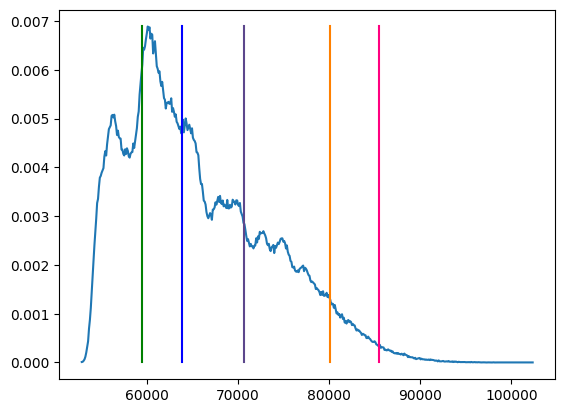

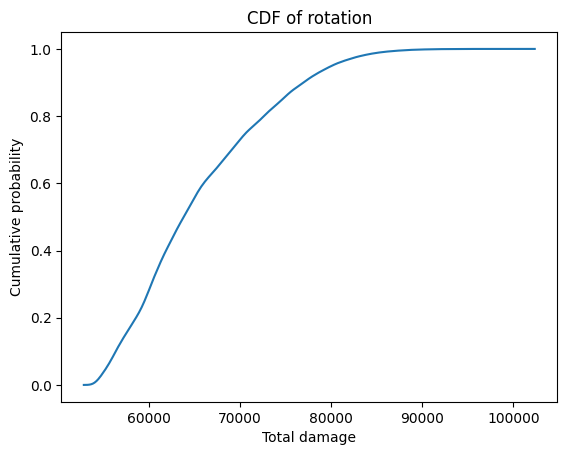

In [42]:
#@title display example
SKILL_LIBRARY = create_test_skill_library()
stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, job_class = 'test_job')
processed_stats =  ProcessedStats(stats)
skill = SKILL_LIBRARY.get_skill('test_guaranteed_dh', 'test_job')

dmg_instances = [
                 (3040, SKILL_LIBRARY.get_skill('test_guaranteed_dh', 'test_job'), (StatusEffects(), StatusEffects())),
                 (6000, SKILL_LIBRARY.get_skill('test_gcd', 'test_job'), (StatusEffects(), StatusEffects())),
                 (7000, SKILL_LIBRARY.get_skill('test_gcd', 'test_job'), (StatusEffects(dh_rate_add=0.1), StatusEffects())),
                 (8000, SKILL_LIBRARY.get_skill('test_gcd', 'test_job'), (StatusEffects(dh_rate_add=0.1), StatusEffects())),
                 (9000, SKILL_LIBRARY.get_skill('test_gcd', 'test_job'), (StatusEffects(dh_rate_add=0.1), StatusEffects()))
                 ]

sim = DamageSimulator(stats, dmg_instances, 1000000)

damage = sim.get_raw_damage()
DisplayUtils.display_results(damage)

res = sim.get_per_skill_damage(dmg_instances)
print(res)

In [43]:
#@title DamageSimulatorTest
class DamageSimulatorTest(TestClass):
  def __init__(self):
    stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=708, job_class = 'test_job')
    self.__processed_stats = ProcessedStats(stats)

  @TestClass.is_a_test
  def test_guaranteed_crit_dh_dot(self):
    dmg_instances = [
                 (0, SKILL_LIBRARY.get_skill('test_guaranteed_crit_dot', 'test_job'), (StatusEffects(), StatusEffects())),
                 (1000, SKILL_LIBRARY.get_skill('test_guaranteed_dh_dot', 'test_job'), (StatusEffects(), StatusEffects())),
                 (2000, SKILL_LIBRARY.get_skill('test_guaranteed_crit_dh_dot', 'test_job'), (StatusEffects(), StatusEffects()))]
    sim = DamageSimulator(self.__processed_stats.stats, dmg_instances, 2)
    expected_crit = [1, self.__processed_stats.crit_rate, 1]
    expected_dh = [self.__processed_stats.dh_rate, 1, 1]
    (actual_crit, actual_dh) = sim.get_crit_and_dh_rates()
    (test_passed_crit, err_msg_crit) = self._compare_sequential(actual_crit, expected_crit)
    (test_passed_dh, err_msg_dh) = self._compare_sequential(actual_dh, expected_dh)
    return test_passed_crit and test_passed_dh, err_msg_crit+err_msg_dh

  @TestClass.is_a_test
  def test_guaranteed_crit_dh(self):
    dmg_instances = [
                 (0, SKILL_LIBRARY.get_skill('test_guaranteed_crit', 'test_job'), (StatusEffects(), StatusEffects())),
                 (1000, SKILL_LIBRARY.get_skill('test_guaranteed_dh', 'test_job'), (StatusEffects(), StatusEffects())),
                 (2000, SKILL_LIBRARY.get_skill('test_guaranteed_crit_dh', 'test_job'), (StatusEffects(), StatusEffects()))]
    sim = DamageSimulator(self.__processed_stats.stats, dmg_instances, 2)
    expected_crit = [1, self.__processed_stats.crit_rate, 1]
    expected_dh = [self.__processed_stats.dh_rate, 1, 1]
    (actual_crit, actual_dh) = sim.get_crit_and_dh_rates()
    (test_passed_crit, err_msg_crit) = self._compare_sequential(actual_crit, expected_crit)
    (test_passed_dh, err_msg_dh) = self._compare_sequential(actual_dh, expected_dh)
    return test_passed_crit and test_passed_dh, err_msg_crit+err_msg_dh

In [44]:
#@title ComputeDamageUtilsTest
class ComputeDamageUtilsTest(TestClass):
  def __init__(self):
    stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=708, job_class = 'test_job')
    self.__processed_stats = ProcessedStats(stats)
    self.__skill_library = create_test_skill_library()

  @TestClass.is_a_test
  def test_guaranteed_crit_dh_dot_with_buffs(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job')
    processed_stats =  ProcessedStats(stats)
    skill = self.__skill_library.get_skill('test_guaranteed_crit_dh_dot', 'test_job')
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill, processed_stats, (StatusEffects(crit_rate_add=0.25, dh_rate_add=0.2), StatusEffects(crit_rate_add=0.07, dh_rate_add=0.12)))
    expected_base_damage = 1804.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_dh_dot_no_buffs(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job')
    processed_stats =  ProcessedStats(stats)
    skill = self.__skill_library.get_skill('test_guaranteed_crit_dh_dot', 'test_job')
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill, processed_stats, (StatusEffects(), StatusEffects()))
    expected_base_damage = 1419.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_dot_with_buffs(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job')
    processed_stats =  ProcessedStats(stats)
    skill = self.__skill_library.get_skill('test_guaranteed_crit_dot', 'test_job')
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill, processed_stats, (StatusEffects(crit_rate_add=0.32), StatusEffects()))
    expected_base_damage = 1640.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_dot_no_buffs(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job')
    processed_stats =  ProcessedStats(stats)
    skill = self.__skill_library.get_skill('test_guaranteed_crit_dot', 'test_job')
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill, processed_stats, (StatusEffects(), StatusEffects()))
    expected_base_damage = 1376.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_dh_dot_with_buffs(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job')
    processed_stats =  ProcessedStats(stats)
    skill = self.__skill_library.get_skill('test_guaranteed_dh_dot', 'test_job')
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill, processed_stats, (StatusEffects(), StatusEffects(dh_rate_add=0.32)))
    expected_base_damage = 1532.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_dh_dot_no_buffs(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job')
    processed_stats =  ProcessedStats(stats)
    skill = self.__skill_library.get_skill('test_guaranteed_dh_dot', 'test_job')
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill, processed_stats, (StatusEffects(), StatusEffects()))
    expected_base_damage = 1419.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_dh_with_buffs(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job')
    processed_stats =  ProcessedStats(stats)
    skill = self.__skill_library.get_skill('test_guaranteed_dh', 'test_job')
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill, processed_stats, (StatusEffects(dh_rate_add=0.2), StatusEffects(dh_rate_add=0.12)))
    expected_base_damage = 19971.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_with_buffs(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job')
    processed_stats =  ProcessedStats(stats)
    skill = self.__skill_library.get_skill('test_guaranteed_crit', 'test_job')
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill, processed_stats, (StatusEffects(crit_rate_add=0.2), StatusEffects(crit_rate_add=0.12)))
    expected_base_damage = 21396.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_no_buffs(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job')
    processed_stats =  ProcessedStats(stats)
    skill = self.__skill_library.get_skill('test_guaranteed_crit', 'test_job')
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill, processed_stats, (StatusEffects(), StatusEffects()))
    expected_base_damage = 17945.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_dh_no_buffs(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job')
    processed_stats =  ProcessedStats(stats)
    skill = self.__skill_library.get_skill('test_guaranteed_dh', 'test_job')
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill, processed_stats, (StatusEffects(), StatusEffects()))
    expected_base_damage = 18492.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_guaranteed_crit_dh_with_buffs(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_job')
    processed_stats =  ProcessedStats(stats)
    skill = self.__skill_library.get_skill('test_guaranteed_crit_dh', 'test_job')
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill, processed_stats, (StatusEffects(crit_rate_add=0.32), StatusEffects(dh_rate_add=0.32)))
    expected_base_damage = 23527.0
    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_base_damage(self):
    test_passed = True
    err_msg = ""
    skill = self.__skill_library.get_skill('test_gcd', self.__processed_stats.stats.job_class)
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill, self.__processed_stats, (StatusEffects(), StatusEffects()))
    expected_base_damage = 7930.0

    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_dot_tick_damage(self):
    test_passed = True
    err_msg = ""
    skill = self.__skill_library.get_skill('test_dot_tick', self.__processed_stats.stats.job_class)
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill, self.__processed_stats, (StatusEffects(), StatusEffects()))
    expected_base_damage = 1920.0

    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_tank_dot_tick_damage(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=2.96, main_stat=2906, det_stat=1883, crit_stat=2352, dh_stat=868, speed_stat=650, tenacity=631, job_class = 'test_tank_job')
    processed_stats = ProcessedStats(stats)

    skill = self.__skill_library.get_skill('test_tank_dot_tick', processed_stats.stats.job_class)
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill, processed_stats, (StatusEffects(), StatusEffects()))
    expected_base_damage = 1013.0

    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_tank_base_damage(self):
    test_passed = True
    err_msg = ""
    stats = Stats(wd=126, weapon_delay=3.36, main_stat=2910, det_stat=1980, crit_stat=2313, dh_stat=868, speed_stat=592, tenacity=631, job_class = 'test_tank_job')
    processed_stats = ProcessedStats(stats)

    skill = self.__skill_library.get_skill('test_tank_gcd', processed_stats.stats.job_class)
    actual_base_damage = ComputeDamageUtils.get_base_damage(skill, processed_stats, (StatusEffects(), StatusEffects()))
    expected_base_damage = 4316.0

    if not math.isclose(actual_base_damage, expected_base_damage, abs_tol=1e-4):
      test_passed = False
      err_msg = "Base damage is not close. Expected: {}. Actual: {}.".format(expected_base_damage, actual_base_damage)
    return test_passed, err_msg

In [45]:
#@title DamageBuilderTest
class DamageBuilderTest(TestClass):
  def __init__(self):
    self.__stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=708, job_class = 'test_job')
    self.__skill_library = create_test_skill_library()

  @TestClass.is_a_test
  def buff_and_debuff_snapshotting(self):
    # Create input directly
    rb_result = SnapshotAndApplicationEvents()
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'), [True, True])
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_simple_debuff_gcd_2', 'test_job'), [True, True])
    rb_result.add(transform_time_to_prio(2540), 2540, 3040, self.__skill_library.get_skill('test_gcd', 'test_job'), [True, True])
    rb_result.add(transform_time_to_prio(2940), 2940, 3440, self.__skill_library.get_skill('test_dot_gcd', 'test_job'), [True, True])
    rb_result.add(transform_time_to_prio(2940)+1, 2940, 3440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True])
    rb_result.add(transform_time_to_prio(2940)+2, 2940, 6440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True])
    rb_result.add(transform_time_to_prio(2940)+3, 2940, 9440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True])
    rb_result.add(transform_time_to_prio(2940)+4, 2940, 12440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True])
    rb_result.add(transform_time_to_prio(2940)+5, 2940, 15440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True])
    rb_result.add(transform_time_to_prio(12940), 12940, 13440, self.__skill_library.get_skill('test_gcd', 'test_job'), [True, True])

    db = DamageBuilder(self.__skill_library)
    result = db.get_damage_instances(rb_result)

    expected = [(3040, self.__skill_library.get_skill('test_gcd', 'test_job'), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (3440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (6440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (9440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (12440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (13440, self.__skill_library.get_skill('test_gcd', 'test_job'), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.0))),
                (15440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3)))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def buff_and_debuff_snapshotting_with_no_debuff_snapshot(self):

    # Create input directly
    rb_result = SnapshotAndApplicationEvents()
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'), [True, True])
    rb_result.add(0, 0, 0, self.__skill_library.get_skill('test_simple_debuff_gcd_2', 'test_job'), [True, True])
    rb_result.add(transform_time_to_prio(1000), 1000, 1500, self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, False])
    rb_result.add(transform_time_to_prio(1000), 1000, 11000, self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, False])

    db = DamageBuilder(self.__skill_library)
    result = db.get_damage_instances(rb_result)
    expected = [(1500, self.__skill_library.get_skill('test_dot_tick', 'test_job'), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (11000, self.__skill_library.get_skill('test_dot_tick', 'test_job'), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.0)))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def priority_test(self):
    # Create input directly
    rb_result = SnapshotAndApplicationEvents()
    # test_gcd will snapshot AFTER the buff goes out, due to priority handling
    rb_result.add(0, 0, 500, self.__skill_library.get_skill('test_gcd', 'test_job'), [True, True])
    rb_result.add(1, 0, 0, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'), [True, True])

    db = DamageBuilder(self.__skill_library)
    result = db.get_damage_instances(rb_result)
    expected = [(500, self.__skill_library.get_skill('test_gcd', 'test_job'), (StatusEffects(), StatusEffects())),]
    return self._compare_sequential(result, expected)

In [46]:
#@title RotationBuilderAndDamageBuilderIntegrationTest
class RotationBuilderAndDamageBuilderIntegrationTest(TestClass):
  def __init__(self):
    self.__stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=708, job_class = 'test_job')
    self.__skill_library = create_test_skill_library()

  @TestClass.is_a_test
  def buff_and_debuff_snapshotting(self):
    # test_passed = True
    # err_msg = ""

    rb = RotationBuilder(self.__stats, self.__skill_library)
    rb.add_to_rotation('test_simple_buff_gcd', 0.0)
    rb.add_to_rotation('test_simple_debuff_gcd_2', 0.0)
    rb.add_to_rotation('test_gcd', 0.6)
    rb.add_to_rotation('test_dot_gcd', 1.0)
    rb.add_to_rotation('test_gcd', 11.0)

    db = DamageBuilder(self.__skill_library)
    result = db.get_damage_instances(rb.get_skill_timing())

    expected = [(3040, self.__skill_library.get_skill('test_gcd', 'test_job'), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (3440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (6440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (9440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (12440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3))),
                (13440, self.__skill_library.get_skill('test_gcd', 'test_job'), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.0))),
                (15440, self.__skill_library.get_skill('test_dot_tick', 'test_job'), (StatusEffects(crit_rate_add=0.05), StatusEffects(damage_mult=1.3)))]
    return self._compare_sequential(result, expected)

In [47]:
#@title StatusEffectTrackerTest
class StatusEffectTrackerTest(TestClass):
  def __init__(self):
    self.__skill_library = create_test_skill_library()

  @TestClass.is_a_test
  def simple_buff_expiry(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()
    se.add_to_status_effects(1000, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'))
    #test_simple_buff_gcd_2 should expire after 18000 ms
    se.add_to_status_effects(8000, self.__skill_library.get_skill('test_simple_buff_gcd_2', 'test_job'))
    #test_simple_buff_gcd_2 should expire after 19000 ms
    se.add_to_status_effects(9000, self.__skill_library.get_skill('test_simple_debuff_gcd_2', 'test_job'))

    se.expire_status_effects(19001)
    result = se.compile_status_effects()
    expected = (StatusEffects(crit_rate_add=0.05), StatusEffects())

    if (result != expected):
      test_passed = False
      err_msg = "Expected and actual buffs do not match.\nExpected{}.\nActual:{}".format(expected, result)
    return test_passed, err_msg

  @TestClass.is_a_test
  def simple_buffs(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()
    se.add_to_status_effects(100, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'))
    se.add_to_status_effects(100, self.__skill_library.get_skill('test_simple_buff_gcd_2', 'test_job'))
    se.add_to_status_effects(100, self.__skill_library.get_skill('test_simple_debuff_gcd', 'test_job'))
    se.add_to_status_effects(100, self.__skill_library.get_skill('test_simple_debuff_gcd_2', 'test_job'))

    result = se.compile_status_effects()
    expected = (StatusEffects(crit_rate_add=0.11, dh_rate_add=0.2), StatusEffects(damage_mult=1.56))

    if (result != expected):
      test_passed = False
      err_msg = "Expected and actual buffs do not match.\nExpected{}.\nActual:{}".format(expected, result)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_buff_override(self):
    test_passed = True
    err_msg = ""
    se = StatusEffectTracker()
    se.add_to_status_effects(100, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'))
    # this should simply override the first buff
    se.add_to_status_effects(500, self.__skill_library.get_skill('test_simple_buff_gcd', 'test_job'))

    result = se.compile_status_effects()
    expected = (StatusEffects(crit_rate_add=0.05, dh_rate_add=0.0), StatusEffects())

    if (result != expected):
      test_passed = False
      err_msg = "Expected and actual buffs do not match.\nExpected{}.\nActual:{}".format(expected, result)
    return test_passed, err_msg

In [48]:
#@title StatusEffectSpecTest
class StatusEffectSpecTest(TestClass):
  @TestClass.is_a_test
  def test_max_duration(self):
    test_passed = True
    err_msg = ""

    duration = 10000
    status_effect_spec = StatusEffectSpec(duration=duration)
    return test_passed, err_msg
    if (status_effect_spec.max_duration != duration):
      test_passed = False
      err_msg = "Max duration set incorrectly. Expected{} but got {}".format(duration, status_effect_spec.max_duration)
    return test_passed, err_msg

  @TestClass.is_a_test
  def test_set_max_duration(self):
    test_passed = True
    err_msg = ""

    duration = 10000
    max_duration = 30000
    status_effect_spec = StatusEffectSpec(duration=duration, max_duration = max_duration)
    return test_passed, err_msg
    if (status_effect_spec.max_duration != duration):
      test_passed = False
      err_msg = "Max duration set incorrectly. Expected{} but got {}".format(max_duration, status_effect_spec.max_duration)
    return test_passed, err_msg

In [49]:
#@title RotationBuilderUtilTest
class RotationBuilderUtilTest(TestClass):
  def __init__(self):
    self.__stats = Stats(wd=126, weapon_delay=3.44, main_stat=2945, det_stat=1620, crit_stat=2377, dh_stat=1048, speed_stat=708, job_class = 'test_job')
    self.__skill_library = create_test_skill_library()

  @TestClass.is_a_test
  def simple_dot(self):
    test_passed = True
    err_msg = ""

    rb = RotationBuilder(self.__stats, self.__skill_library)
    rb.add_to_rotation('test_dot_gcd', 1.0)

    expected = ((SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_gcd', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 6440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 9440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 12440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 15440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]))
    result = rb.get_skill_timing().get_q()
    result.sort(key=lambda x: x[0])

    # strip out priority from result
    result = [result[i][1:] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def simple_ground_dot(self):
    test_passed = True
    err_msg = ""

    rb = RotationBuilder(self.__stats, self.__skill_library)
    rb.add_to_rotation('test_ground_dot_gcd', 1.0)

    expected = ((SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_ground_dot_gcd', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, False]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 6440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, False]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 9440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, False]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 12440), self.__skill_library.get_skill('test_dot_tick', 'test_job'),[True, False]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 15440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, False]))
    result = rb.get_skill_timing().get_q()
    result.sort(key=lambda x: x[0])

    # strip out priority from result
    result = [result[i][1:] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def dot_with_early_refresh(self):
    test_passed = True
    err_msg = ""

    rb = RotationBuilder(self.__stats, self.__skill_library)
    rb.add_to_rotation('test_dot_gcd', 1.0)
    rb.add_to_rotation('test_dot_gcd', 8.0)

    expected = ((SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_gcd', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 6440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 9440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 10440), self.__skill_library.get_skill('test_dot_gcd', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 10440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 13440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 16440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 19440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 22440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]))
    result = rb.get_skill_timing().get_q()
    result.sort(key=lambda x: x[0])

    # strip out priority from result
    result = [result[i][1:] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def dot_with_early_refresh_from_instant_dot_gcd(self):
    test_passed = True
    err_msg = ""

    rb = RotationBuilder(self.__stats, self.__skill_library)
    rb.add_to_rotation('test_dot_gcd', 1.0)
    rb.add_to_rotation('test_dot_instant_gcd', 8.0)

    expected = ((SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_gcd', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 6440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(8000, None), self.__skill_library.get_skill('test_dot_instant_gcd', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(8000, None), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(8000, 11000), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(8000, 14000), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(8000, 17000), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(8000, 20000), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]))
    result = rb.get_skill_timing().get_q()
    result.sort(key=lambda x: x[0])

    # strip out priority from result
    result = [result[i][1:] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def dot_refresh_with_other_follow_up(self):
    # this is a more complex test because dot refreshes are more likely to mess up the ordering
    # of skills
    test_passed = True
    err_msg = ""

    rb = RotationBuilder(self.__stats, self.__skill_library)

    rb.add_to_rotation('test_dot_gcd_with_other_follow_up', 1.0)
    rb.add_to_rotation('test_dot_gcd_with_other_follow_up', 8.0)

    expected = ((SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_gcd_with_other_follow_up', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_non_dot_follow_up', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 3440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 6440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2940, 9440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 10440), self.__skill_library.get_skill('test_dot_gcd_with_other_follow_up', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 10440), self.__skill_library.get_skill('test_non_dot_follow_up', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 10440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 13440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 16440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 19440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(9940, 22440), self.__skill_library.get_skill('test_dot_tick', 'test_job'), [True, True]))

    result = rb.get_skill_timing().get_q()
    result.sort(key=lambda x: x[0])

    # strip out priority from result
    result = [result[i][1:] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def skill_follow_up_test_non_dot(self):
    test_passed = True
    err_msg = ""

    rb = RotationBuilder(self.__stats, self.__skill_library)
    rb.add_to_rotation('test_follow_up',0)

    expected = ((SnapshotAndApplicationEvents.EventTimes(1940, 2440), self.__skill_library.get_skill('test_follow_up', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(1940, 2440), self.__skill_library.get_skill('test_non_dot_follow_up', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(1940, 3000+2440), self.__skill_library.get_skill('test_non_dot_follow_up', 'test_job'), [False, True]),
                (SnapshotAndApplicationEvents.EventTimes(7000+2440, None), self.__skill_library.get_skill('test_non_dot_follow_up', 'test_job'), [True, True]))
    result = rb.get_skill_timing().get_q()
    result.sort(key=lambda x: x[0])

    # strip out priority from result
    result = [result[i][1:] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

  @TestClass.is_a_test
  def skill_timing_test_no_buffs_no_dot(self):
    test_passed = True
    err_msg=""

    # For a 2500 ms gcd, this spell speed should result in a 2440 sm (2.44s) GCD.
    rb = RotationBuilder(self.__stats, self.__skill_library)
    rb.add_to_rotation('test_gcd', 0)
    rb.add_to_rotation('test_gcd', 3.5)
    rb.add_to_rotation('test_ogcd', 2.4)
    rb.add_to_rotation('test_gcd_with_app_delay', 4.0)

    expected = ((SnapshotAndApplicationEvents.EventTimes(1940, 2440), self.__skill_library.get_skill('test_gcd', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(2400, None), self.__skill_library.get_skill('test_ogcd', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(3500+1940, 3500+2440), self.__skill_library.get_skill('test_gcd', 'test_job'), [True, True]),
                (SnapshotAndApplicationEvents.EventTimes(4000+1940, 4000+2440+100), self.__skill_library.get_skill('test_gcd_with_app_delay', 'test_job'), [True, True]))

    result = rb.get_skill_timing().get_q()
    result.sort(key=lambda x: x[0])

    # strip out priority from result
    result = [result[i][1:] for i in range(0, len(result))]
    return self._compare_sequential(result, expected)

In [50]:
#@title TimingSpecTest
class TimingSpecTest(TestClass):
  @TestClass.is_a_test
  def gcd_override_gcd_test(self):
    test_passed = True
    err_msg=""
    cast_spec = TimingSpec(base_cast_time=2000, is_GCD=True)
    if cast_spec.gcd_base_recast_time != 2500:
      err_msg = "Recast time was expected to be 2500, but it was {}.".format(cast_spec.gcd_base_recast_time)
      test_passed = False
    return test_passed, err_msg

  @TestClass.is_a_test
  def gcd_override_ogcd_test(self):
    test_passed = True
    err_msg=""
    cast_spec = TimingSpec(base_cast_time=2000, is_GCD=False)
    if cast_spec.gcd_base_recast_time != 0:
      err_msg = "Recast time was expected to be 0, but it was {}.".format(cast_spec.gcd_base_recast_time)
      test_passed = False
    return test_passed, err_msg

  @TestClass.is_a_test
  def gcd_override_set_recast_time(self):
    test_passed = True
    err_msg=""
    cast_spec = TimingSpec(base_cast_time=2000, gcd_base_recast_time=1500, base_recast_time=60000, is_GCD=False)
    if cast_spec.gcd_base_recast_time != 1500:
      err_msg = "Recast time was expected to be 1500, but it was {}.".format(cast_spec.gcd_base_recast_time)
      test_passed = False
    return test_passed, err_msg

In [55]:
#@title StatFnsTest
#TODO: fdetdh test
class StatFnsTest(TestClass):
  @TestClass.is_a_test
  def get_time_using_speed_stat_test(self):
    test_passed = True
    err_msg=""

    gcd_inputs_and_expcted= {2500: ((1408, 1409, 1410), (2330, 2320, 2320)),
                             3500: ((999, 1000, 1001), (3360, 3350, 3350))}

    for gcd_time, inputs_and_outputs in gcd_inputs_and_expcted.items():
      speed_stat = inputs_and_outputs[0]
      expected = inputs_and_outputs[1]
      for i in range(0, len(speed_stat)):
          gcd_actual = StatFns.get_time_using_speed_stat(gcd_time, speed_stat[i])
          gcd_expected = expected[i]
          if gcd_actual != gcd_expected:
            err_msg += "gcd_time expected: {}. Actual: {}. For {} gcd.\n".format(gcd_expected, gcd_actual, gcd_time)
            test_passed = False

    return test_passed, err_msg

  @TestClass.is_a_test
  def get_crit_stats_test(self):
    test_passed = True
    err_msg=""

    crit_stat_inputs_and_expected = {400: (0.05, 0.40),
                                     475: (0.057, 0.407),
                                     476: (0.058, 0.408),
                                     1150: (0.128, 0.478),
                                     1151: (0.129, 0.479),
                                     1152: (0.129, 0.479)}

    for crit_stat, expected in crit_stat_inputs_and_expected.items():
      #TODO: consider using math.isclose isntead for float comparison fiddliness.
      crit_rate_actual, crit_bonus_actual = StatFns.get_crit_stats(crit_stat)
      if (crit_rate_actual, crit_bonus_actual) != expected:
        err_msg += "crit stat: {}. crit rate/bonus expected: {}/{}. Actual: {}/{}.\n".format(crit_stat, expected[0], expected[1], crit_rate_actual, crit_bonus_actual)
        test_passed = False

    return test_passed, err_msg

  @TestClass.is_a_test
  def fDetDH_test(self):
    test_passed = True
    err_msg=""

    #(det_stat, dh_stat, fDetDh_expected)
    stat_inputs_and_expected = ((390, 400, 1000+0),
                                (1706, 1360, 1096+70),
                                (1707, 1369, 1097+71))

    for (det_stat, dh_stat, expected) in stat_inputs_and_expected:
      fDetDH_actual = StatFns.fDetDH(det_stat, dh_stat)
      if fDetDH_actual != expected:
        err_msg += "fDetDh expected: {}. Actual: {}.\n".format(expected, fDetDH_actual)
        test_passed = False
    return test_passed, err_msg

  @TestClass.is_a_test
  def fDet_test(self):
    test_passed = True
    err_msg=""

    det_stat_inputs_and_expected = {390: 1000,
                                    566: 1012,
                                    567: 1013,
                                    1706: 1096,
                                    1707: 1097,
                                    1708: 1097}

    for det_stat, expected in det_stat_inputs_and_expected.items():
      fDet_actual = StatFns.fDet(det_stat)
      if fDet_actual != expected:
        err_msg += "fDet expected: {}. Actual: {}.\n".format(expected, fDet_actual)
        test_passed = False
    return test_passed, err_msg

  @TestClass.is_a_test
  def dh_rate_test(self):
    test_passed = True
    err_msg=""

    dh_stat_inputs_and_expected = {400: 0,
                                   472: 0.020,
                                   473: 0.021,
                                   1360: 0.277,
                                   1361: 0.278,
                                   1362: 0.278}

    for dh_stat, expected in dh_stat_inputs_and_expected.items():
      dh_rate_actual = StatFns.get_dh_rate(dh_stat)
      if not math.isclose(dh_rate_actual, expected, abs_tol=1e-4):
        err_msg += "dh_rate expected: {}. Actual: {}.\n".format(expected, dh_rate_actual)
        test_passed = False
    return test_passed, err_msg

  @TestClass.is_a_test
  def wd_test(self):
    test_passed = True
    err_msg=""

    #(wd, job_mod, fWd_expected)
    wd_stat_inputs_and_expected = ((120, 100, 159),
                                   (126, 115, 170))

    for (wd, job_mod, expected) in wd_stat_inputs_and_expected:
      fWD_actual = StatFns.fWD(wd, job_mod)
      if fWD_actual != expected:
        err_msg += "fWd expected: {}. Actual: {}.\n".format(expected, fWD_actual)
        test_passed = False
    return test_passed, err_msg

  @TestClass.is_a_test
  def spd_test(self):
    test_passed = True
    err_msg=""

    #(spd, fSpd_expected)
    spd_stat_inputs_and_expected = ((859, 1031),
                                    (1700,  1088))

    for (spd, expected) in spd_stat_inputs_and_expected:
      fSpd_actual_actual = StatFns.fSpd(spd)
      if fSpd_actual_actual != expected:
        err_msg += "fSpd expected: {}. Actual: {}.\n".format(expected, fSpd_actual_actual)
        test_passed = False
    return test_passed, err_msg

  @TestClass.is_a_test
  def fTnc_test(self):
    test_passed = True
    err_msg=""

    tnc_inputs_and_expected = {751: 1018,
                               1100: 1036,
                               500: 1005}

    for tnc, expected in tnc_inputs_and_expected.items():
      fTnc_actual = StatFns.fTnc(tnc)
      if fTnc_actual != expected:
        err_msg += "fTnc expected: {}. Actual: {}.\n".format(expected, fTnc_actual)
        test_passed = False
    return test_passed, err_msg

  @TestClass.is_a_test
  def fAP_tank_test(self):
    test_passed = True
    err_msg=""

    ap_inputs_and_expected = {390: 100,
                              699: 223,
                              1219: 431}

    for ap, expected in ap_inputs_and_expected.items():
      fAP_actual = StatFns.fAP(ap, is_tank = True)
      if fAP_actual != expected:
        err_msg += "fAP expected: {}. Actual: {}.\n".format(expected, fAP_actual)
        test_passed = False
    return test_passed, err_msg

  @TestClass.is_a_test
  def fAP_non_tank_test(self):
    test_passed = True
    err_msg=""

    ap_inputs_and_expected = {390: 100,
                              699: 254,
                              1219: 514}

    for ap, expected in ap_inputs_and_expected.items():
      fAP_actual = StatFns.fAP(ap, is_tank = False)
      if fAP_actual != expected:
        err_msg += "fAP expected: {}. Actual: {}.\n".format(expected, fAP_actual)
        test_passed = False
    return test_passed, err_msg

In [56]:
TimingSpecTest().run_all()
StatusEffectSpecTest().run_all()
StatFnsTest().run_all()
RotationBuilderUtilTest().run_all()
StatusEffectTrackerTest().run_all()
RotationBuilderAndDamageBuilderIntegrationTest().run_all()
DamageBuilderTest().run_all()
ComputeDamageUtilsTest().run_all()
DamageSimulatorTest().run_all()

Testing for TimingSpecTest. 3/3 tests passed.
Passing tests:
gcd_override_gcd_test
gcd_override_ogcd_test
gcd_override_set_recast_time
Testing for StatusEffectSpecTest. 2/2 tests passed.
Passing tests:
test_max_duration
test_set_max_duration
Testing for StatFnsTest. 10/10 tests passed.
Passing tests:
dh_rate_test
fAP_non_tank_test
fAP_tank_test
fDetDH_test
fDet_test
fTnc_test
get_crit_stats_test
get_time_using_speed_stat_test
spd_test
wd_test
Testing for RotationBuilderUtilTest. 7/7 tests passed.
Passing tests:
dot_refresh_with_other_follow_up
dot_with_early_refresh
dot_with_early_refresh_from_instant_dot_gcd
simple_dot
simple_ground_dot
skill_follow_up_test_non_dot
skill_timing_test_no_buffs_no_dot
Testing for StatusEffectTrackerTest. 3/3 tests passed.
Passing tests:
simple_buff_expiry
simple_buffs
test_buff_override
Testing for RotationBuilderAndDamageBuilderIntegrationTest. 1/1 tests passed.
Passing tests:
buff_and_debuff_snapshotting
Testing for DamageBuilderTest. 3/3 tests passed.